In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

import cPickle as pickle

from osgeo import ogr, gdal, osr
import fiona

from shapely.geometry import shape, Point, Polygon, MultiLineString, MultiPoint, MultiPolygon, LineString
from shapely import affinity

from scipy.ndimage import morphology

from utilities import *



import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd
import cPickle as pickle

from osgeo import ogr, gdal, osr
import fiona
from shapely.geometry import shape, Point, Polygon, MultiLineString, MultiPoint, MultiPolygon, LineString


from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

import matplotlib
import matplotlib as mpl
inline_rc = dict(mpl.rcParams)

import seaborn as sns


import clusterpy


import itertools
from sklearn.neighbors import KDTree


import pysal as ps
from sklearn import cluster
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster
from scipy.cluster import hierarchy

from scipy.stats import percentileofscore


from collections import defaultdict
# %pylab inline
import pandas as pd
from scipy.cluster.hierarchy import dendrogram, set_link_color_palette
# from fastcluster import linkage
import seaborn as sns
from matplotlib.colors import rgb2hex, colorConverter
# from matplotlib.pyplot import *
import matplotlib

ClusterPy: Library of spatially constrained clustering algorithms


/anaconda3/envs/ml/lib/python2.7/site-packages/pysal/__init__.py:65: VisibleDeprecationWarning: PySAL's API will be changed on 2018-12-31. The last release made with this API is version 1.14.4. A preview of the next API version is provided in the `pysal` 2.0 prelease candidate. The API changes and a guide on how to change imports is provided at https://pysal.org/about
  ), VisibleDeprecationWarning)
/anaconda3/envs/ml/lib/python2.7/site-packages/numba/decorators.py:33: NumbaDeprecationWarning: autojit is deprecated, use jit instead, which provides the same functionality. For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-numba-autojit
  warnings.warn(NumbaDeprecationWarning(msg))


In [2]:
network_filepath = '_input/network.shp'
island_filepath = '_input/islands.shp'
patch_filepath = '_input/patches.shp' # outlines of channels, not shorelines

calculate_params = False

In [3]:
# load island shapefile
islands, _ = load_shapefile(island_filepath)

# load patch shapefile
patches, _ = load_shapefile(patch_filepath)

# load network shapefile
network_lines, params = load_shapefile(network_filepath, parameters = ['Width'])
network_widths = params['Width']

In [4]:
# identify network lines that surround islands (bounding channels) or that drain islands (interior channels)

if calculate_params:

    # get midpoints of all network lines, with buffers so they touch both neighbors
    midpts = [l.interpolate(0.5, normalized=True).buffer(5) for l in network_lines]

    bounding_channels = []
    interior_channels = []

    # compare the location of midpts to island patches
    for polygon in patches:

        # if midpoint intersects patch, the line is a bounding channel
        touch = [i for i,l in enumerate(midpts) if polygon.exterior.intersects(l)]
        bounding_channels.append(touch)

        # if midpoint is completely within patch, the line is an interior channel
        touch = [i for i,l in enumerate(midpts) if polygon.contains(l)]
        interior_channels.append(touch)

    pickle.dump(bounding_channels, open( '_input_processed/bounding_channels' + '.p', "wb" ) )
    pickle.dump(interior_channels, open( '_input_processed/interior_channels' + '.p', "wb" ) )
    
else:
    
    bounding_channels = pickle.load( open( '_input_processed/bounding_channels.p', "rb" ))
    interior_channels = pickle.load( open( '_input_processed/interior_channels.p', "rb" ))


In [5]:
# Base metrics

interior_lengths = [sum([network_lines[j].length for j in interior_channels[i]]) if len(interior_channels[i])>0 else 0 for i in range(len(islands))] 

perimeter = np.array([i.boundary.length for i in islands])
wetted_perimeter = perimeter + 2 * np.array(interior_lengths)   
area = np.array([i.area for i in islands])
perimeter_convex_hull = np.array([i.convex_hull.exterior.length for i in islands])
area_convex_hull = np.array([i.convex_hull.area for i in islands])

a = np.array(map(Polygon_axes, islands))
major_axis = a[:,1]
minor_axis = a[:,0]
aspect_ratio = major_axis / minor_axis

circularity = 4 * np.pi * area / perimeter**2
equivalent_area_diameter = np.sqrt((4 / np.pi) * area)
perimeter_equivalent_diameter = area / np.pi
solidity = area / area_convex_hull
concavity = area_convex_hull - area
convexity = perimeter_convex_hull / perimeter
dry_shape_factor = perimeter / np.sqrt(area)
wet_shape_factor = wetted_perimeter / np.sqrt(area)

polygon_metrics = {'Area': area,
                'Perimeter': perimeter,
                'WetPerim': wetted_perimeter,
                'CH_Area': area_convex_hull,
                'CH_Perim': perimeter_convex_hull,
                'AspectR': aspect_ratio,
                'Circular': circularity,
                'Solidity': solidity,
                'Concavity': concavity,
                'Convexity': convexity,
                'DryShapeF': dry_shape_factor,
                'WetShapeF': wet_shape_factor
                  }

pickle.dump(polygon_metrics,
            open( '_metrics/metrics__base_metrics' + '.p', "wb" ) ) 

In [6]:
# Calculate maximum distance from the any water body

if calculate_params:

    maximum_edge_distance = np.zeros((len(islands),))
    cellsize = 30

    for n,i in enumerate(islands):

        print n

        minx, miny, maxx, maxy = i.bounds

        minx = np.floor(minx) - 1 * cellsize
        maxx = np.ceil(maxx) + 1 * cellsize
        miny = np.floor(miny) - 1 * cellsize
        maxy = np.ceil(maxy) + 1 * cellsize

        x = np.arange(minx, maxx , cellsize)
        y = np.arange(miny, maxy , cellsize)

        mask = outline_to_mask(i.exterior, x, y)
        distmap = morphology.distance_transform_edt(mask)

        maximum_edge_distance[n] = distmap.max() * cellsize

        mask = dist = None

    pickle.dump(maximum_edge_distance, open( '_metrics/metrics__edge_distance' + '.p', "wb" ) )

else:
    
    maximum_edge_distance = pickle.load( open( '_metrics/metrics__edge_distance.p', "rb" ))   

    
polygon_metrics['EdgeDist'] = maximum_edge_distance
    
    

In [7]:
# calculate bounding channel width statistics for each island

if calculate_params:

    network_min_widths = np.zeros((len(islands),))
    network_avg_widths = np.zeros((len(islands),))
    network_max_widths = np.zeros((len(islands),))

    for n in range(len(islands)):

        i = islands[n]

        # network lines off coast (for closing patches) have width 9999 - ignore
        channels = [network_lines[b] for b in bounding_channels[n] if network_widths[b] != 9999]
        widths = [network_widths[b] for b in bounding_channels[n] if network_widths[b] != 9999]
        lengths = [c.length for c in channels]


        tot_length = sum(lengths)
        network_avg_widths[n] = sum([widths[b] * lengths[b] for b in range(len(widths))]) / tot_length
        network_max_widths[n] = max(widths)
        network_min_widths[n] = min(widths)

    pickle.dump([network_min_widths, network_avg_widths, network_max_widths],
                open( '_metrics/metrics__bounding_channel_widths' + '.p', "wb" ) )

else:
        
    network_min_widths, network_avg_widths, network_max_widths = pickle.load( open( '_metrics/metrics__bounding_channel_widths.p', "rb" ))
    
polygon_metrics['Max_Width'] = network_max_widths
polygon_metrics['Min_Width'] = network_min_widths
polygon_metrics['Avg_Width'] = network_avg_widths

In [8]:
# count the number of outflow channels
# by counting the number of interior channels that cross the boundary of the island
# We use patches instead of islands to avoid false positives where wide channels are
# preserved in the outline of islands

if calculate_params:

    num_outflow = np.zeros((len(islands),), dtype = 'int')

    for n in range(len(islands)):

        lines = [i for i in interior_channels[n]]

        # interior channels that touch the boundary
        outflow = []

        for l in lines:
            if network_lines[l].intersects(patches[n].exterior):
                outflow.append(l)

        num_outflow[n] = len(outflow)

    pickle.dump(num_outflow,
                open( '_metrics/metrics__outflow_channels' + '.p', "wb" ) )

else:
    
    num_outflow = pickle.load( open( '_metrics/metrics__outflow_channels.p', "rb" ))
    
polygon_metrics['NumOutflow'] = num_outflow

polygon_metrics['Norm_Out'] = num_outflow / polygon_metrics['Area']

In [9]:
def fractal_dimension(Z, threshold=0.9):

    # From https://github.com/rougier/numpy-100 (#87)
    def boxcount(Z, k):
        S = np.add.reduceat(
            np.add.reduceat(Z, np.arange(0, Z.shape[0], k), axis=0),
                               np.arange(0, Z.shape[1], k), axis=1)

        # Count non-empty (0) and non-full boxes (k*k)
        return len(np.where((S > 0) & (S < k*k))[0])

    p = min(Z.shape)
    n = 2**np.floor(np.log(p)/np.log(2))
    n = int(np.log(n)/np.log(2))
    sizes = 2**np.arange(n, 1, -1)

    # Box counting with decreasing size
    counts = []
    for size in sizes:
        counts.append(boxcount(Z, size))

    # Fit the successive log(sizes) with log (counts)
    coeffs = np.polyfit(np.log(sizes), np.log(counts), 1)
    return -coeffs[0]



if calculate_params:

    fractal_dimensions = np.zeros((len(islands),))

    for j in range(len(islands)):

        print j

        outline = patches[j].exterior.simplify(15)
        _,_,angle = Polygon_axes(outline)
        outline = affinity.rotate(outline, angle, origin='centroid')

        minx, miny, maxx, maxy = outline.bounds

        cellsize = 5

        if (maxy - miny > 10000) or (maxx - minx > 10000):
            cellsize = 30

        if (maxy - miny > 50000) or (maxx - minx > 50000):
            cellsize = 60

        minx = np.floor(minx) - 1 * cellsize
        maxx = np.ceil(maxx) + 1 * cellsize
        miny = np.floor(miny) - 1 * cellsize
        maxy = np.ceil(maxy) + 1 * cellsize

        x = np.arange(minx, maxx , cellsize)
        y = np.arange(miny, maxy , cellsize)

        mask = outline_to_mask(outline, x, y)
        fractal_dimensions[j] = fractal_dimension(mask)

        mask = None

    pickle.dump(fractal_dimensions, open( '_metrics/metrics__fractal_dimensions' + '.p', "wb" ) )    
    
else:
    
    fractal_dimensions = pickle.load( open( '_metrics/metrics__fractal_dimensions.p', "rb" ))
    
    
polygon_metrics['FractalD'] = fractal_dimensions

In [10]:
pickle.dump(polygon_metrics,
            open( '_metrics/metrics__all_metrics' + '.p', "wb" ) )

In [11]:
field_type = {}

for k in polygon_metrics.keys():
    
    if polygon_metrics[k][0].dtype == 'float':
        field_type[k] = ogr.OFTReal
        
    if polygon_metrics[k][0].dtype == 'int':
        field_type[k] = ogr.OFTInteger

        
        
create_shapefile_from_shapely_multi(islands,
                            '_output/islands_properties.shp',
                            fields = polygon_metrics,
                            field_type = field_type)


In [12]:
def load_shapefile(filename, parameters = []):


    
    c = fiona.open(filename)

    if c[0]['geometry']['type'] == 'Polygon':
        shp = MultiPolygon([shape(pol['geometry']) for pol in c])

    elif c[0]['geometry']['type'] == 'LineString':
        shp = MultiLineString([shape(pol['geometry']) for pol in c])

    elif c[0]['geometry']['type'] == 'Point':
        shp = MultiPoint([shape(pol['geometry']) for pol in c])

    else:
        shp = [shape(pol['geometry']) for pol in c]
        
        
    
    if parameters is 'all':
        parameters = c[0]['properties'].keys()
        
    if type(parameters) is not list:
    
        parameters = list(parameters)


    shp_params = {}

    for param in parameters:
        shp_params[param] = [line['properties'][param] for line in c]

    c = None

    return shp, shp_params

def create_shapefile_from_shapely_multi(features, filename,
                                        fields = {}, field_type = {},
                                        buffer_width = 0, spatial_ref = 32645):
    '''
    Creates a shapefile from a
    Shapely MultiPolygon, MultiLineString, or MultiPoint
    '''


    driver = ogr.GetDriverByName('Esri Shapefile')
    ds = driver.CreateDataSource(filename)

    srs = osr.SpatialReference()
    srs.ImportFromEPSG(spatial_ref)

    layer = ds.CreateLayer('', srs, ogr.wkbPolygon)

    for f in fields.keys():
        fieldDefn = ogr.FieldDefn(f, field_type[f])
        layer.CreateField(fieldDefn)

    defn = layer.GetLayerDefn()


    for i in range(len(features)):

        poly = features[i].buffer(buffer_width)

        # Create a new feature (attribute and geometry)
        feat = ogr.Feature(defn)

        for f in fields.keys():
            feat.SetField(f, fields[f][i])

        # Make a geometry from Shapely object
        geom = ogr.CreateGeometryFromWkb(poly.wkb)
        feat.SetGeometry(geom)

        layer.CreateFeature(feat)
        feat = geom = None  # destroy these


    # Save and close everything
    ds = layer = feat = geom = None

In [13]:
properties_shapefile_filepath = '_output/islands_properties.shp'
islands, parameters = load_shapefile(properties_shapefile_filepath, parameters='all')

parameters = pickle.load( open( '_metrics/metrics__all_metrics.p', "rb" ))

In [14]:
parameters.keys()

['CH_Area',
 'Perimeter',
 'WetPerim',
 'AspectR',
 'Area',
 'Solidity',
 'WetShapeF',
 'FractalD',
 'Max_Width',
 'Concavity',
 'Norm_Out',
 'NumOutflow',
 'DryShapeF',
 'Min_Width',
 'EdgeDist',
 'Avg_Width',
 'CH_Perim',
 'Convexity',
 'Circular']

In [15]:
normalized_parameters = pd.DataFrame()


for k in parameters.keys():
    
    params = np.array(parameters[k])
    
    if params.min() == 0:
        vals = np.log10(params + 0.1)
        vals[vals == -1] = 0
    
    else:
        vals = np.log10(params / params.min())
    
    normalized_parameters[k.encode('utf-8')] = vals

cols = ['Area',#'CH_Area','EdgeDist',
#          'Perimeter','WetPerim','CH_Perim',
         'AspectR',#'MajorAxis','MinorAxis',
         'DryShapeF',#'WetShapeF',
        'FractalD',
#         'Norm_Out',
         'Min_Width','Max_Width','Avg_Width',
        'NumOutflow',
#         'Concavity',
        #'Circular',
        'Solidity','Convexity',
       ]
    #                                  'P_Eq_Diam','Eq_A_Diam']
    
    
normalized_parameters = normalized_parameters[cols]
    
scaled_data = MinMaxScaler().fit_transform(normalized_parameters.values)
scaled_parameters = pd.DataFrame(data = scaled_data, columns = normalized_parameters.columns)

pickle.dump(scaled_parameters,
            open( '_metrics/metrics__scaled_parameters' + '.p', "wb" ) )

In [16]:
field_type = {}

for k in scaled_parameters.keys():
    field_type[k] = ogr.OFTReal
       

create_shapefile_from_shapely_multi(islands,
                                    '_output/islands_properties_scaled.shp',
                                    fields = scaled_parameters,
                                    field_type = field_type)

In [17]:
# Modified from http://www.ritchieng.com/machine-learning-project-customer-segments/
def pca_results_funct(good_data, pca, plot = False):
    '''
    Create a DataFrame of the PCA results
    Includes dimension feature weights and explained variance
    Visualizes the PCA results
    '''

    # Dimension indexing
    dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = good_data.keys())
    components.index = dimensions

    # PCA explained variance
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
    variance_ratios.index = dimensions

    if plot:
        
        # Create a bar plot visualization
        fig, ax = plt.subplots(figsize = (14,8))

        # Plot the feature weights as a function of the components
        components.plot(ax = ax, kind = 'bar');
        ax.set_ylabel("Feature Weights")
        ax.set_xticklabels(dimensions, rotation=0)


        # Display the explained variance ratios
        for i, ev in enumerate(pca.explained_variance_ratio_):
            ax.text(i-0.40, ax.get_ylim()[1] + 0.05, "Explained Variance\n          %.4f"%(ev))

    # Return a concatenated DataFrame
    return pd.concat([variance_ratios, components], axis = 1)

In [18]:
# PCA

'''Principal component analysis (PCA) is a statistical procedure
that uses an orthogonal transformation to convert a set of
observations of possibly correlated variables into a set of
values of linearly uncorrelated variables called principal components
'''

noise = 0

pca = PCA(n_components=6)
pca.fit(scaled_parameters + noise)

# TODO: Transform the good data using the PCA fit above
reduced_data = pca.transform(scaled_parameters + noise)


# Create a DataFrame for the reduced data
reduced_data = pd.DataFrame(reduced_data)
reduced_data.columns = ['PCA' + str(k) for k in reduced_data.columns.values if type(k) <> 'str']

pd.to_pickle(reduced_data, '_PCA/pca__reduced_data.p')

pca_results = pca_results_funct(scaled_parameters + noise, pca)
explained_variance = pca.explained_variance_ratio_
print 'Explained variance:', sum(explained_variance)*100, '%'

# pd.to_pickle(explained_variance,'_PCA/pca__explained_variance.p')

field_type = {}

for k in reduced_data.keys():
    field_type[k] = ogr.OFTReal

pca_filename = '_output/pca_dimensions.shp'

create_shapefile_from_shapely_multi(islands,
                                    pca_filename,
                                    fields = reduced_data,
                                    field_type = field_type)

Explained variance: 95.02444744714876 %


In [25]:
def predict_geosom(data):
    
    for k in c_data.Y.keys():
        c_data.Y[k] = [k] + list(data[k,:])

    c_data.cluster("geoSom", params, alphaType='linear',
                   nRows=nRows, nCols=nCols, wType="queen",
                   iters = 1000, num_neighboring_neurons = 2,
                  fileName = '_PCA/' + str(nRows) + 'x' + str(nCols)
                  )
    c_data.exportArcData(clusterpy_output_dir + '/classes_' + directory)
    c_data.exportOutputs(clusterpy_output_dir + '/output_' + directory + ".csv")

    c_data.outputCluster = {'r2a': [], 'r2aRoot': []}
    
    
    return np.array(c_data.region2areas)

In [26]:
clusterpy_output_dir = '_clusterpy'
c_data = clusterpy.importArcData(pca_filename[:-4])
params = reduced_data.columns.tolist()

n, m = 20,20

directory = str(n) + 'x' + str(m)
print directory

nRows = n
nCols = m
regions = predict_geosom(reduced_data.values)

Loading _output/pca_dimensions.dbf
Loading _output/pca_dimensions.shp
Done
20x20
The parameters dissolve and dataOperations is not available for the this algorithm
Geo-Som
---Generating geo SOM topology---
Creating grid
Done
Processing geometric areas
Done
Processing geometric areas
Done
Getting variables
Variables successfully extracted
Generating Uniform
Done [Uniform]
Getting variables
Variables successfully extracted
FINAL SOLUTION:  [1, 1, 1, 2, 0, 1, 1, 2, 2, 7, 4, 1, 8, 1, 3, 2, 1, 1, 0, 1, 3, 1, 7, 3, 3, 1, 30, 4, 3, 9, 10, 8, 13, 9, 3, 15, 15, 3, 8, 8, 8, 8, 7, 8, 15, 10, 8, 8, 3, 7, 10, 8, 15, 7, 3, 16, 16, 4, 9, 9, 8, 16, 16, 5, 12, 16, 9, 21, 9, 12, 11, 9, 22, 10, 6, 6, 12, 17, 16, 11, 22, 18, 11, 14, 9, 30, 18, 11, 11, 11, 31, 20, 17, 32, 19, 19, 19, 24, 18, 19, 18, 32, 11, 18, 23, 23, 21, 24, 23, 24, 24, 22, 18, 32, 24, 24, 24, 18, 24, 24, 22, 23, 18, 22, 19, 19, 23, 23, 23, 25, 18, 25, 23, 18, 22, 24, 22, 18, 41, 54, 45, 20, 35, 35, 25, 46, 34, 28, 43, 67, 34, 36, 26, 36

In [29]:
reduced_data = pickle.load( open( '_PCA/pca__reduced_data.p', "rb" ))

nRows, nCols = 20,20

island_classes, class_num = load_shapefile('_clusterpy/classes_20x20.shp', parameters=['geoSom_2019'])
neurons, count = load_shapefile('_PCA/20x20.shp', parameters=['ID','iter999'])



count_gt_zero = [n for n,l in enumerate(count['iter999']) if l>0]

count = np.array(count['iter999']).astype('int').reshape((nRows,nCols))
label_count = [i for i in count.flatten() if i > 0]

unique_classes = np.unique(class_num['geoSom_2019'])
all_classes = np.array(class_num['geoSom_2019'])






new_classes = np.zeros((len(all_classes),), dtype = 'int')

for n,i in enumerate(unique_classes):
    
    loc = all_classes == i
    new_classes[loc] = count_gt_zero[n]

all_classes = new_classes.copy()

mean_vals = pd.DataFrame(index = np.unique(all_classes))

for c in reduced_data.columns:
    
    for n,l in enumerate(np.unique(all_classes)):
        
        loc = list(np.where(all_classes == l)[0])
        
        mean_vals.loc[l,c] = np.mean(reduced_data.loc[loc,c])

mean_vals = mean_vals.fillna(0)

all_classes = new_classes.copy()
unique_classes = np.unique(all_classes)

U_matrix = np.ones(((nRows*2) - 1, (nCols*2) - 1)) * 9999
labels = np.arange(nRows * nCols).reshape((nRows,nCols))
labels[count == 0] = -1


labels[count == 0] = -1
n_labels = labels.copy()
n_labels[labels > -1] = range(len(unique_classes))

distances = squareform(pdist(mean_vals, metric = 'euclidean'))
distances_pd = pd.DataFrame(data = distances, index = unique_classes, columns = unique_classes)

neurons2 = MultiPolygon([i for n,i in enumerate(neurons) if count.flatten()[n] > 0.0])
W = ps.weights.Queen.from_iterable(neurons2)
neighbors = W.neighbors

n_neighbors = {}
for k in neighbors.keys():
    n_neighbors[labels[n_labels == k][0]] = [labels[n_labels == i][0] for i in neighbors[k]]

    
    
U_matrix = np.ones(((nRows*2) - 1, (nCols*2) - 1)) * 9999

for k in n_neighbors.keys():

    row, col = np.where(labels == k)
    i = row[0]
    j = col[0]
    row_ind = (i * 2)
    col_ind = (j * 2)

    neigh = n_neighbors[k]

    val_sum = 0
    val_count = 0

    if len(neigh) > 0:
        for n in neigh:

            rown, coln = np.where(labels == n)
            i1 = rown[0]
            j1 = coln[0]

            row_ind1 = (i1 * 2)
            col_ind1 = (j1 * 2)

            row_ind_mid = row_ind + (i1 - i)
            col_ind_mid = col_ind + (j1 - j)

            U_matrix[row_ind_mid, col_ind_mid] = distances_pd.loc[k,n]
            val_sum += U_matrix[row_ind_mid, col_ind_mid]
            val_count += 1.


        U_matrix[row_ind, col_ind] = val_sum / val_count
        
    else:
        
        U_matrix[row_ind, col_ind] = 9999
     

/anaconda3/envs/ml/lib/python2.7/site-packages/pysal/weights/weights.py:186: UserWarning: There is one disconnected observation (no neighbors)
  warnings.warn("There is one disconnected observation (no neighbors)")
/anaconda3/envs/ml/lib/python2.7/site-packages/pysal/weights/weights.py:187: UserWarning: Island id: 166
  warnings.warn("Island id: %s" % str(self.islands[0]))


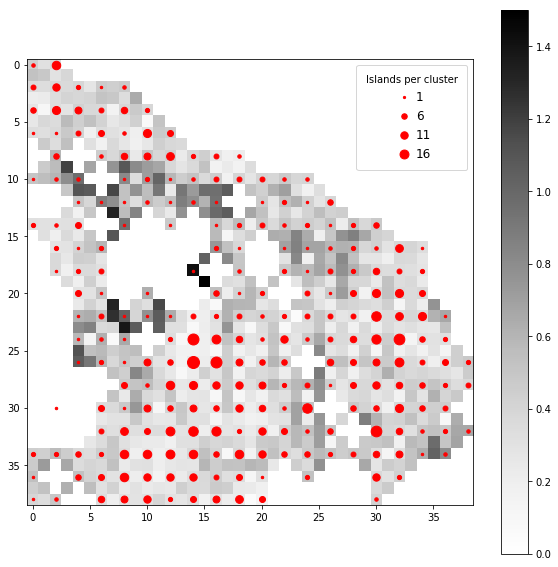

In [30]:
U_matrix_masked = np.ma.masked_where(U_matrix > 100 , U_matrix)

plt.figure(figsize=(10,10))
plt.imshow(U_matrix_masked, vmin = 0, vmax = 1.5, cmap = 'Greys')
plt.colorbar()

for n,k in enumerate(labels.flatten()):
    
    if k > -1:

        row, col = np.where(labels == k)
        j = row[0]
        i = col[0]

        plt.scatter(i*2, j*2, c='r', s = count.flatten()[n] * 6)

        
msizes = np.linspace(1,16,4) * 5

l1 = plt.scatter([],[], c='r', s = msizes[0])
l2 = plt.scatter([],[], c='r', s = msizes[1])
l3 = plt.scatter([],[], c='r', s = msizes[2])
l4 = plt.scatter([],[], c='r', s = msizes[3])

legend_labels = ['1', '6', '11', '16']

leg = plt.legend([l1, l2, l3, l4], legend_labels, ncol=1, frameon=True, fontsize=12,
handlelength=2, loc = 1, borderpad = 0.8,
handletextpad=0, title='Islands per cluster', scatterpoints = 1)

In [31]:
def get_distances(X,model,mode='l2'):
    distances = []
    weights = []
    children=model.children_
    dims = (X.shape[1],1)
    distCache = {}
    weightCache = {}
    for childs in children:
        c1 = X[childs[0]].reshape(dims)
        c2 = X[childs[1]].reshape(dims)
        c1Dist = 0
        c1W = 1
        c2Dist = 0
        c2W = 1
        if childs[0] in distCache.keys():
            c1Dist = distCache[childs[0]]
            c1W = weightCache[childs[0]]
        if childs[1] in distCache.keys():
            c2Dist = distCache[childs[1]]
            c2W = weightCache[childs[1]]
        d = np.linalg.norm(c1-c2)
        cc = ((c1W*c1)+(c2W*c2))/(c1W+c2W)

        X = np.vstack((X,cc.T))

        newChild_id = X.shape[0]-1

        # How to deal with a higher level cluster merge with lower distance:
        if mode=='l2':  # Increase the higher level cluster size suing an l2 norm
            added_dist = (c1Dist**2+c2Dist**2)**0.5 
            dNew = (d**2 + added_dist**2)**0.5
        elif mode == 'max':  # If the previrous clusters had higher distance, use that one
            dNew = max(d,c1Dist,c2Dist)
        elif mode == 'actual':  # Plot the actual distance.
            dNew = d


        wNew = (c1W + c2W)
        distCache[newChild_id] = dNew
        weightCache[newChild_id] = wNew

        distances.append(dNew)
        weights.append( wNew)
    return distances, weights

connectivity = W.full()[0]



Agg_c5 = cluster.AgglomerativeClustering(n_clusters = 5, compute_full_tree=True,
                                      connectivity = connectivity, affinity='euclidean', linkage='ward',)  
AggLabels5 = Agg_c5.fit_predict(mean_vals.values)


Agg_c14 = cluster.AgglomerativeClustering(n_clusters = 14, compute_full_tree=True,
                                      connectivity = connectivity, affinity='euclidean', linkage='ward',)  
AggLabels14 = Agg_c14.fit_predict(mean_vals.values)

Agg_c15 = cluster.AgglomerativeClustering(n_clusters = 15, compute_full_tree=True,
                                      connectivity = connectivity, affinity='euclidean', linkage='ward',)  
AggLabels15 = Agg_c15.fit_predict(mean_vals.values)


Agg_c30 = cluster.AgglomerativeClustering(n_clusters = 30, compute_full_tree=True,
                                      connectivity = connectivity, affinity='euclidean', linkage='ward',)  
AggLabels30 = Agg_c30.fit_predict(mean_vals.values)

distance, weight = get_distances(mean_vals.values, Agg_c14, mode='l2')
linkage_matrix = np.column_stack([Agg_c14.children_, distance, weight]).astype(float)

/anaconda3/envs/ml/lib/python2.7/site-packages/sklearn/cluster/hierarchical.py:244: UserWarning: the number of connected components of the connectivity matrix is 2 > 1. Completing it to avoid stopping the tree early.
  affinity='euclidean')


In [32]:
fields = {}


for k in range(5,31,1):
    
    Agg = cluster.AgglomerativeClustering(n_clusters = k, compute_full_tree=True, connectivity = connectivity, affinity='euclidean', linkage='ward')  
    l = Agg.fit_predict(mean_vals.values) 
    
    
    c = np.zeros((len(island_classes),), dtype = 'int')
    
    for n,i in enumerate(unique_classes):
        
        loc = np.where(all_classes == i)[0]
        c[loc] = l[n]
        
    
    fields[str(k)] = c

    
fields['id'] = range(len(island_classes))

field_type = {}
for k in fields.keys():
    field_type[str(k)] = ogr.OFTInteger

create_shapefile_from_shapely_multi(island_classes,
                                    '_output/agg_classes.shp',
                                    fields = fields,
                                    field_type = field_type)

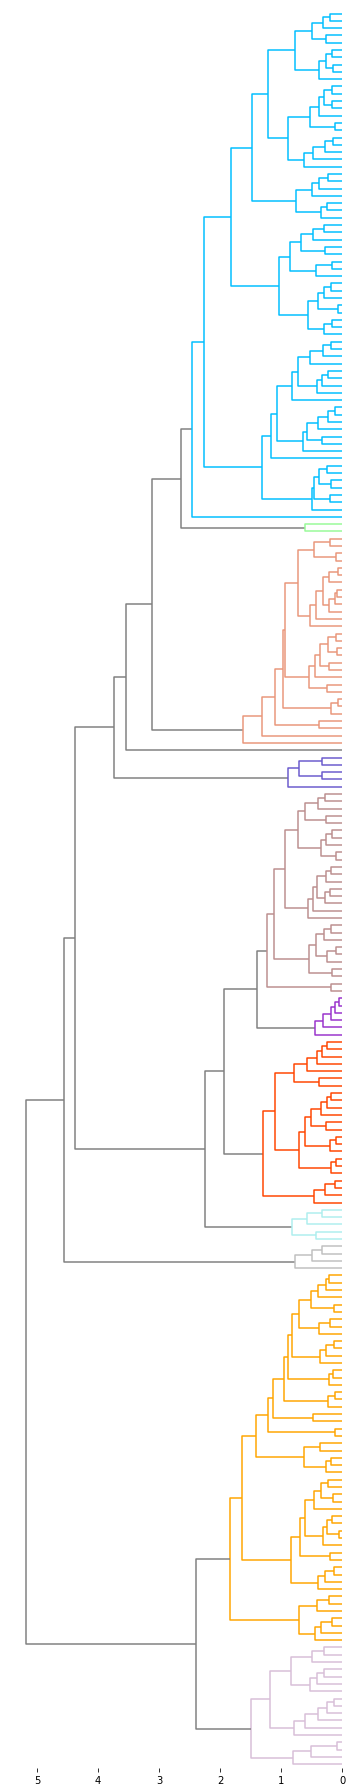

In [34]:

Agg_c12 = cluster.AgglomerativeClustering(n_clusters = 12, compute_full_tree=True,
                                      connectivity = connectivity, affinity='euclidean', linkage='ward',)  
AggLabels12 = Agg_c12.fit_predict(mean_vals.values)

distance, weight = get_distances(mean_vals.values, Agg_c12, mode='l2')
linkage_matrix = np.column_stack([Agg_c12.children_, distance, weight]).astype(float)


den = dendrogram(linkage_matrix, no_plot = True)


cluster_idxs = defaultdict(list)
for c, pi in zip(den['color_list'], den['icoord']):
    for leg in pi[1:3]:
        i = (leg - 5.0) / 10.0
        if abs(i - int(i)) < 1e-5:
            cluster_idxs[c].append(int(i))



dendrogram_labels = []
for i in den['leaves']:
    dendrogram_labels.append(list(np.where(all_classes == i)[0]))


temp = {den["leaves"][ii]: dendrogram_labels[ii] for ii in range(len(den["leaves"]))}
def llf(xx):
#     return "({})".format(temp[xx])
    return "{}".format('')

color_dict12 = {0: 'deepskyblue', 1: 'darksalmon', 2: 'silver', 3: 'orange', 4: 'orangered',
               5: 'paleturquoise', 6:'violet', 7:'rosybrown', 8:'thistle', 9:'slateblue',
               10: 'darkorchid', 11:'palegreen'}

dflt_col = "#808080" 
link_cols = {}
for i, i12 in enumerate(linkage_matrix[:,:2].astype(int)):
    
    c1, c2 = (link_cols[x] if x > len(linkage_matrix) else color_dict12[AggLabels12[x]]
    for x in i12)
    link_cols[i+1+len(linkage_matrix)] = c1 if c1 == c2 else dflt_col


plt.figure(figsize=(5,25))
den = dendrogram(linkage_matrix,
                 leaf_label_func=llf,
#                  link_color_func = lambda k: new_color_list[k],
                 link_color_func=lambda x: link_cols[x],
                leaf_font_size=6,
                orientation = 'left'
                )
plt.yticks(rotation=0)


no_spine = {'left': True, 'bottom': True, 'right': True, 'top': True}
sns.despine(**no_spine);

# labels5 = [[i for ni,i in enumerate(AggLabels14[den['leaves']]) if AggLabels5[den['leaves']][ni] == n] for n in [1,2,3,4,0]]
# dendrogram_labels_color = []
# colors = ['deepskyblue', 'g', 'orange', 'rebeccapurple', 'indianred']
# for n,i in enumerate(color_sublist):
#     dendrogram_labels_color += [colors[n]] * len(labels5[n])
    
# dendrogram_labels_color = [color_dict14[AggLabels14[x]] for x in den['leaves']]
    
    


ax = plt.gca()
# ax.yaxis.tick_right()
# ylbls = ax.get_ymajorticklabels()
# for n,y in enumerate(ylbls):
#     y.set_color(dendrogram_labels_color[n])
    
    
    


fig = plt.gcf()
dx = 0
dy = 0.05
offset = matplotlib.transforms.ScaledTranslation(dx,dy, fig.dpi_scale_trans)

# apply offset transform to all x ticklabels.
for label in ax.yaxis.get_majorticklabels():
    label.set_transform(label.get_transform() + offset)
plt.tight_layout()

plt.savefig('_test/agg_test12_vertical.png', dpi = 300)

In [35]:
def get_U_matrix_sized_labels(labels, thin = False):

    U_matrix_labels = np.zeros(((nRows*2) - 1, (nCols*2) - 1))
    U_matrix_labels_diff = np.zeros(((nRows*2) - 1, (nCols*2) - 1))

    U_matrix_labels[0::2, 0::2] = labels + 1

    U_matrix_labels_diff[0::2, 1::2] = np.diff(labels)

    for i in range(0,nCols*2 - 2,2):

        right_cell = U_matrix_labels_diff[0::2, i+1]
        U_matrix_labels[0::2, i+1][right_cell == 0] = U_matrix_labels[0::2, i][right_cell == 0]


    U_matrix_labels_diff[1::2,:] = np.diff(U_matrix_labels[0::2,:], axis = 0)



    for i in range(0,nRows*2 - 2,2):

        bottom_cell = U_matrix_labels_diff[i+1, 0::2]
        U_matrix_labels[i+1, 0::2][bottom_cell == 0] = U_matrix_labels[i, 0::2][bottom_cell == 0]


    # for i in range(0,nCols - 1,2):

    #     U_matrix_labels_diff[1::2, i*2+1] = labels14[:-1,i] - labels14[1:,i+1]


    # NW
    for i in range(1,nCols):

        for j in range(1,nRows):

            l1 = U_matrix_labels[j*2, i*2]
            l2 = U_matrix_labels[j*2 - 2, i*2 - 2]

            if (l1 == l2) & (l1 > 0):
                if thin:
                    if (U_matrix_labels[j*2, i*2 - 2] == l1) & (U_matrix_labels[j*2 - 2, i*2] == l1):
                        U_matrix_labels[j*2 - 1, i*2 - 1] = l1
                else:
                    U_matrix_labels[j*2 - 1, i*2 - 1] = l1



    # SE            
    for i in range(0,nCols-1):

        for j in range(1,nRows):

            l1 = U_matrix_labels[j*2, i*2]
            l2 = U_matrix_labels[j*2 - 2, i*2 + 2]

            if (l1 == l2) & (l1 > 0):
                if thin:
                    if (U_matrix_labels[j*2, i*2 + 2] == l1) & (U_matrix_labels[j*2 - 2, i*2] == l1):
                        U_matrix_labels[j*2 - 1, i*2 + 1] = l1
                else: 
                    U_matrix_labels[j*2 - 1, i*2 + 1] = l1
    
    return U_matrix_labels



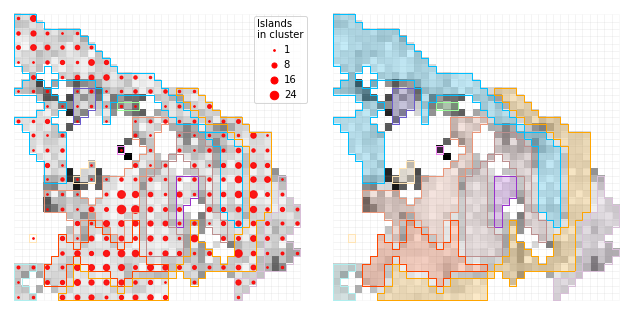

In [36]:
import rasterio
from rasterio.features import shapes as rasterio_shapes
from shapely.geometry import shape
from descartes import PolygonPatch
import matplotlib as mpl
from shapely.affinity import translate
from matplotlib.patches import Polygon
%matplotlib inline



color_dict12 = {0: 'deepskyblue', 1: 'darksalmon', 2: 'moccasin', 3: 'orange', 4: 'orangered',
               5: 'paleturquoise', 6:'violet', 7:'rosybrown', 8:'thistle', 9:'slateblue',
               10: 'darkorchid', 11:'palegreen'}

labels12 = np.zeros((400,)) -1
labels12[labels.flatten() != -1] = AggLabels12

labels12 = labels12.reshape(20,20)


image = np.arange(0,39 * 39).reshape(39,39).astype('int16')
# image[U_matrix > 100] = 9999 
results = (
{'properties': {'raster_val': v}, 'geometry': s}
for i, (s, v) 
in enumerate(
    rasterio_shapes(image)))

geoms = list(results)

label12_shapes_all = MultiPolygon([shape(i['geometry']) for i in geoms])
label12_shapes_all = translate(label12_shapes_all, xoff=-0.5, yoff=-0.5)


# U_matrix_labels5 = get_U_matrix_sized_labels(labels5, thin = True)


# image = U_matrix_labels5.astype('int16')
# results = (
# {'properties': {'raster_val': v}, 'geometry': s}
# for i, (s, v) 
# in enumerate(
#     rasterio_shapes(image)))

# geoms = list(results)

# label5_shapes = MultiPolygon([shape(i['geometry']) for i in geoms if i['properties']['raster_val'] > -1])
# label5_shapes_number = [int(i['properties']['raster_val'])-1 for i in geoms if i['properties']['raster_val'] > -1]

# label5_shapes = translate(label5_shapes, xoff=-0.5, yoff=-0.5)

U_matrix_labels = get_U_matrix_sized_labels(labels12)
# # cheating
# U_matrix_labels[27,1] = 8.
# U_matrix_labels[37,33] = 2.
# U_matrix_labels[11,11] = 11.
# U_matrix_labels[29,31] = 9.


label_count12 = {}

for k in np.unique(labels12):
    
    if k > -1:
        
        orig_labels = labels[labels12 == k]

        n = 0
        for i in orig_labels:
            n += np.sum(all_classes == i)

        label_count12[k] = n


image = U_matrix_labels.astype('int16')
results = (
{'properties': {'raster_val': v}, 'geometry': s}
for i, (s, v) 
in enumerate(
    rasterio_shapes(image)))

geoms = list(results)

label12_shapes = MultiPolygon([shape(i['geometry']) for i in geoms if i['properties']['raster_val'] > 0])
label12_shapes_number = [int(i['properties']['raster_val'])-1 for i in geoms if i['properties']['raster_val'] > 0]

label12_shapes = translate(label12_shapes, xoff=-0.5, yoff=-0.5)





U_matrix_masked = np.ma.masked_where(U_matrix > 100 , U_matrix)

f, (ax1, ax2) = plt.subplots(1,2, figsize=(9, 5))

im = ax1.imshow(U_matrix_masked, cmap = 'Greys', vmin = 0, vmax = 1.5)

for n,k in enumerate(labels.flatten()):
    
    if k > -1:

        row, col = np.where(labels == k)
        j = row[0]
        i = col[0]

        ax1.scatter(i*2, j*2, c='r', s = count.flatten()[n] * 3, alpha = 0.9)

        
msizes = np.linspace(1 * 3, count.max() * 3,4)

l1 = ax1.scatter([],[], c='r', s = msizes[0])
l2 = ax1.scatter([],[], c='r', s = msizes[1])
l3 = ax1.scatter([],[], c='r', s = msizes[2])
l4 = plt.scatter([],[], c='r', s = msizes[3])

legend_labels = [str(int((i) / 3.)) for i in msizes]

leg = ax1.legend([l1, l2, l3, l4], legend_labels, ncol=1, frameon=True, fontsize=10,
handlelength=2, loc = 1, borderpad = 0.3,
handletextpad=0, title='Islands\nin cluster', scatterpoints = 1)

patches = [PolygonPatch(feature, edgecolor='0.6',
                        facecolor="None", linewidth=0.5, alpha = 0.1) for n,feature in enumerate(label12_shapes_all)]
ax1.add_collection(mpl.collections.PatchCollection(patches, match_original=True))


selected_patches = range(12)

patches = [PolygonPatch(feature, edgecolor=color_dict12[label12_shapes_number[n]],
                        facecolor="None", linewidth=1, alpha = 1) for n,feature in enumerate(label12_shapes)
                         if label12_shapes_number[n] in selected_patches]
ax1.add_collection(mpl.collections.PatchCollection(patches, match_original=True))

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['bottom'].set_visible(False)

ax1.axes.get_xaxis().set_visible(False)
ax1.axes.get_yaxis().set_visible(False)

ax1.set_xlim(-1, 40)
ax1.set_ylim(40, -1)












U_matrix_labels = get_U_matrix_sized_labels(labels12)
# # cheating
# U_matrix_labels[27,1] = 8.
# U_matrix_labels[37,33] = 2.
# U_matrix_labels[11,11] = 11.
# U_matrix_labels[29,31] = 9.


label_count12 = {}

for k in np.unique(labels12):
    
    if k > -1:
        
        orig_labels = labels[labels12 == k]

        n = 0
        for i in orig_labels:
            n += np.sum(all_classes == i)

        label_count12[k] = n


image = U_matrix_labels.astype('int16')
results = (
{'properties': {'raster_val': v}, 'geometry': s}
for i, (s, v) 
in enumerate(
    rasterio_shapes(image)))

geoms = list(results)

label12_shapes = MultiPolygon([shape(i['geometry']) for i in geoms if i['properties']['raster_val'] > 0])
label12_shapes_number = [int(i['properties']['raster_val'])-1 for i in geoms if i['properties']['raster_val'] > 0]

label12_shapes = translate(label12_shapes, xoff=-0.5, yoff=-0.5)



im = ax2.imshow(U_matrix_masked, cmap = 'Greys', vmin = 0, vmax = 1.5)
# plt.colorbar(im, ax=ax2, orientation="horizontal", pad=0)



selected_patches = range(14)

patches = [PolygonPatch(feature, edgecolor='0.6',
                        facecolor="None", linewidth=0.5, alpha = 0.1) for n,feature in enumerate(label12_shapes_all)]
ax2.add_collection(mpl.collections.PatchCollection(patches, match_original=True))

patches = [PolygonPatch(feature, edgecolor=color_dict12[label12_shapes_number[n]],
                        facecolor="None", linewidth=1, alpha = 1) for n,feature in enumerate(label12_shapes)
                         if label12_shapes_number[n] in selected_patches]
ax2.add_collection(mpl.collections.PatchCollection(patches, match_original=True))

patches = [PolygonPatch(feature, edgecolor=color_dict12[label12_shapes_number[n]],
                        facecolor=color_dict12[label12_shapes_number[n]], linewidth=1, alpha = 0.2) for n,feature in enumerate(label12_shapes)
                         if label12_shapes_number[n] in selected_patches]
ax2.add_collection(mpl.collections.PatchCollection(patches, match_original=True))



ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['bottom'].set_visible(False)

ax2.axes.get_xaxis().set_visible(False)
ax2.axes.get_yaxis().set_visible(False)

ax2.set_xlim(-1, 40)
ax2.set_ylim(40, -1)


plt.tight_layout(h_pad = -2)

plt.savefig('_test/U_matrices.png', dpi = 300)

In [37]:
den['leaves']

[197,
 216,
 181,
 196,
 116,
 149,
 164,
 165,
 132,
 148,
 215,
 195,
 163,
 180,
 240,
 228,
 229,
 38,
 50,
 39,
 49,
 63,
 61,
 62,
 224,
 209,
 225,
 226,
 232,
 233,
 235,
 238,
 239,
 236,
 237,
 234,
 221,
 222,
 202,
 220,
 191,
 158,
 176,
 210,
 227,
 192,
 211,
 193,
 212,
 194,
 213,
 214,
 178,
 162,
 179,
 147,
 146,
 130,
 131,
 74,
 73,
 86,
 98,
 114,
 75,
 87,
 99,
 115,
 166,
 102,
 90,
 103,
 198,
 199,
 217,
 230,
 231,
 151,
 185,
 169,
 170,
 208,
 206,
 207,
 187,
 154,
 172,
 205,
 223,
 184,
 203,
 186,
 204,
 201,
 219,
 218,
 183,
 200,
 167,
 182,
 126,
 157,
 142,
 125,
 109,
 110,
 70,
 82,
 156,
 174,
 188,
 155,
 173,
 175,
 189,
 190,
 83,
 160,
 95,
 111,
 127,
 177,
 143,
 159,
 107,
 124,
 123,
 140,
 141,
 93,
 108,
 69,
 81,
 94,
 54,
 42,
 43,
 31,
 32,
 79,
 133,
 67,
 134,
 135,
 117,
 118,
 119,
 150,
 168,
 136,
 152,
 171,
 122,
 139,
 137,
 153,
 80,
 104,
 138,
 120,
 105,
 121,
 92,
 91,
 106,
 56,
 68,
 57,
 58,
 45,
 46,
 30,
 51,
 52

In [38]:
labels12

array([[ 0.,  0., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1., -1., -1., -1.],
       [ 0.,  0.,  0.,  0.,  0., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1., -1., -1., -1.],
       [ 0.,  0.,  0.,  0.,  0.,  0., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1., -1., -1., -1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1., -1., -1., -1.],
       [-1.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1., -1., -1.,
        -1., -1., -1., -1., -1., -1., -1.],
       [ 0.,  0.,  0., -1.,  9.,  9.,  0.,  0.,  0.,  0.,  0.,  3.,  3.,
        -1., -1., -1., -1., -1., -1., -1.],
       [-1., -1.,  0.,  0.,  9.,  9.,  0., 11., 11., -1.,  0.,  0.,  3.,
         3., -1., -1., -1., -1., -1., -1.],
       [ 0.,  0.,  0., -1.,  9., -1.,  0., -1.,  1.,  1.,  1.,  0.,  0.,
         3.,  3.,  3., -1., -1., -1., -1.],
       [-1.,  0.,  0.,  0., -1., -1., -1., -1.,  1.,  1., -1.,  

In [39]:
islands, parameters = load_shapefile('_output/agg_classes.shp', parameters=['12'])
AggClasses = np.array(parameters['12'])

In [40]:
label_dict = {0: 'Tidal 1', 1: 'Transitional 2', 2: 'Inactive', 3: 'Fluvial 1', 4: 'Fluvial 2',
               5: 'Tidal 2', 6:'Estuarine 2', 7:'Transitional 1', 8:'Estuarine 3', 9:'Estuarine 4',
               10: 'Estuarine 1', 11:'Other', -1:''}

groups = {2: [0,5], #Tidal
         1:[6,8,9,10], #Estuarine
         3: [3,4], #Fluvial
         5:[2], #Inactive
         4:[1,7], #Transitional
         6:[11]} #Other


labels = {2: 'Tidal',
         1: 'Estuarine',
         3: 'Fluvial',
         5: 'Inactive',
         4: 'Transitional',
         6:'Other'}

In [ ]:
grouped_labels = np.zeros_like(AggClasses)

In [ ]:
for key in groups.keys():
    
    for value in groups[key]:
        
        grouped_labels[AggClasses == value] = key

In [ ]:
scaled_parameters = pickle.load( open( '_metrics/metrics__scaled_parameters' + '.p', "rb" ) )

In [ ]:
import matplotlib.gridspec as gridspec

'''
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

The final classification scheme uses
threshold = 0.8
distance = 0.3

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
'''

groups = [10,6,8,9,-1,0,5,-1,3,4,-1,7,1,-1,2,-1,11]


cmap = plt.cm.gray
norm = mpl.colors.Normalize(vmin=-1, vmax=0)

r = 0.3
# cols = [i for i in data.columns if i != 'class']

data = scaled_parameters.copy()


# for col in data.columns:
    
#     data[col] = data[col] - (data[col].mean() - 0.5)



data['class'] = AggClasses
ioi_classes =  groups
cols = scaled_parameters.columns
cols_clean = ['Area', 'Aspect Ratio', 'Dry Shape\nFactor', 'Fractal\nDimension', 'Minimum\nChannel Width',
       'Maximum\nChannel Width', 'Average\nChannel Width', 'Number of\nOutflow Channels', 'Solidity', 'Convexity']
# islands_of_interest = [252, 624, 694, 808, 1027, 1005, 1000, 1053, 210, 193]

# ioi_classes_all = [data.loc[i,'class'] for i in islands_of_interest]
# ioi_classes = np.unique(ioi_classes_all)


# ioi_classes = [0,3,6,4,7,1,2,16,9]
# fig, axes = plt.subplots(nrows=len(cols), ncols=1, figsize=(6, 19))

vals_all = []


plt.figure(figsize = (5, 13))
gs1 = gridspec.GridSpec(len(cols),1)
gs1.update(wspace=0.075, hspace=0.05, left=0.1, right=0.95, bottom = .1, top = 0.98) # set the spacing between axes. 

axes = [plt.subplot(gs1[i]) for i in range(len(cols))]

for nn,col in enumerate(cols):

    axes[nn].set_facecolor('1')

    vals = [list(data.loc[data['class'] == i, col]- 0.5) if i>-1 else 0 for i in ioi_classes]
    vals_med = [np.median(i) for i in vals]

    vals_all.append(vals_med)

    parts = axes[nn].violinplot(vals[:-1], range(len(ioi_classes)-1), points=20, widths=0.7,
                          showmeans=False, showextrema=True, showmedians=True,);

    
    axes[nn].scatter(np.ones_like(vals[-1]) * len(ioi_classes)-1, vals[-1], c = 'k', marker = 'x', lw = 1)
    
    for n,pc in enumerate(parts['bodies']):
        pc.set_facecolor('w')#cmap(norm(vals_med[n])))
        pc.set_edgecolor('black')
        pc.set_alpha(1)
        pc.set_linewidth(1)

    for c in parts.keys():
        if c != 'bodies':
            vp = parts[c]
            vp.set_edgecolor('black')
            vp.set_linewidth(1)

    axes[nn].axhline(0, color='black', lw = 0.5)
#     axes[nn].plot(line_range, np.ones_like(line_range) * 0.5, 'k--', lw = 1, zorder = 1)
    axes[nn].set_ylim(-0.6,0.6)
    axes[nn].tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False)
    axes[nn].set_xticks(np.unique(data['class']))
#     axes[nn].grid(color='0.5', linestyle='--', linewidth=1)
#     axes[nn].axis(False);
#     axes[nn].spines['top'].set_visible(False)
#     axes[nn].spines['right'].set_visible(False)
#     axes[nn].spines['bottom'].set_visible(False)
#     axes[nn].spines['left'].set_visible(False)

    h = axes[nn].set_ylabel(cols_clean[nn], labelpad = 5,
                            horizontalalignment = 'center',
                            verticalalignment = 'bottom')
    h.set_rotation(90)
    axes[nn].set_xlim(-0.5,len(ioi_classes) - 0.5);#data['class'].max() + 0.5)

axes[nn].tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=True)
axes[nn].set_xticks(np.arange(len(ioi_classes)))
axes[nn].set_xticklabels([label_dict[i] for i in ioi_classes], rotation = 90);
# axes[nn].set_xlabel('Island classes')


fig.subplots_adjust(left=0.3)
fig.subplots_adjust(right=0.95)

plt.savefig('_figures/violin_single_groups.png', dpi = 150)
plt.show()

In [ ]:
field_type = {}

for k in scaled_parameters.keys():
    field_type[k] = ogr.OFTReal

filename = '_output/scaled_parameters.shp'

create_shapefile_from_shapely_multi(islands,
                                    filename,
                                    fields = scaled_parameters,
                                    field_type = field_type)

In [ ]:
import matplotlib.gridspec as gridspec

'''
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

The final classification scheme uses
threshold = 0.8
distance = 0.3

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
'''

cmap = plt.cm.gray
norm = mpl.colors.Normalize(vmin=-0.8, vmax=0.1)

r = 0.3
# cols = [i for i in data.columns if i != 'class']

data = scaled_parameters.copy()

# for col in data.columns:
    
#     data[col] = data[col] - (data[col].mean() - 0.5)




data['class'] = grouped_labels
ioi_classes =  range(1,7)
cols = scaled_parameters.columns
cols_clean = cols
# islands_of_interest = [252, 624, 694, 808, 1027, 1005, 1000, 1053, 210, 193]

# ioi_classes_all = [data.loc[i,'class'] for i in islands_of_interest]
# ioi_classes = np.unique(ioi_classes_all)


# ioi_classes = [0,3,6,4,7,1,2,16,9]
# fig, axes = plt.subplots(nrows=len(cols), ncols=1, figsize=(6, 19))

vals_all = []


plt.figure(figsize = (6, 19))
gs1 = gridspec.GridSpec(len(cols),1)
gs1.update(wspace=0.075, hspace=0.1, left=0.3, right=0.95) # set the spacing between axes. 

axes = [plt.subplot(gs1[i]) for i in range(len(cols))]

for nn,col in enumerate(cols):

    axes[nn].set_facecolor('0.9')

    vals = [list(data.loc[data['class'] == i, col]- 0.5) for i in ioi_classes]
    vals_med = [np.median(i) for i in vals]

    vals_all.append(vals_med)

    parts = axes[nn].violinplot(vals, range(len(ioi_classes)), points=20, widths=0.6,
                          showmeans=False, showextrema=True, showmedians=True,);

    for n,pc in enumerate(parts['bodies']):
        pc.set_facecolor('w')#cmap(norm(vals_med[n])))
        pc.set_edgecolor('black')
        pc.set_alpha(1)
        pc.set_linewidth(1)

    for c in parts.keys():
        if c != 'bodies':
            vp = parts[c]
            vp.set_edgecolor('black')
            vp.set_linewidth(1)

    axes[nn].axhline(0, color='black', lw = 0.5)
#     axes[nn].plot(line_range, np.ones_like(line_range) * 0.5, 'k--', lw = 1, zorder = 1)
    axes[nn].set_ylim(-0.7,0.7)
    axes[nn].tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False)
    axes[nn].set_xticks(np.unique(data['class']))
#     axes[nn].grid(color='0.5', linestyle='--', linewidth=1)
#     axes[nn].axis(False);
    axes[nn].spines['top'].set_visible(False)
    axes[nn].spines['right'].set_visible(False)
    axes[nn].spines['bottom'].set_visible(False)
    axes[nn].spines['left'].set_visible(False)

    h = axes[nn].set_ylabel(cols_clean[nn], labelpad = 5, horizontalalignment = 'right', verticalalignment = 'center')
    h.set_rotation(0)
    axes[nn].set_xlim(-0.5,len(ioi_classes) - 0.5);#data['class'].max() + 0.5)

axes[nn].tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=True)
axes[nn].set_xticks(np.arange(len(ioi_classes)))
axes[nn].set_xticklabels(labels.values(), rotation = 90);
axes[nn].set_xlabel('Major island groups')


fig.subplots_adjust(left=0.3)
fig.subplots_adjust(right=0.95)

plt.savefig('_figures/violin_major_groups.png')
plt.show()

In [ ]:
from scipy.stats import entropy

In [ ]:
KL = pd.DataFrame(columns=data.columns[:-1], index = [i for i in ioi_classes if i > -1])

for col in data.columns[:-1]:
    
    for i in ioi_classes:
        
        if i > -1:

            d0 = data.loc[data['class'] == i, col]
            # d0 = d0 / d0.sum()
            d1 = data.loc[data['class'] != i, col]
            # d1 = d1 / d1.sum()

            count_d0, bins = np.histogram(d0, bins = 20, range = (0,1), density = True)
            count_d1, bins = np.histogram(d1, bins = 20, range = (0,1), density = True)

            KL.loc[i, col] = entropy(count_d0 / count_d0.sum() + 0.000001, count_d1 / count_d1.sum() + 0.000001)

In [ ]:
KL

In [ ]:

KLo = KL.values.astype('float').T.copy()

KLo[KLo < 1] = 0

mpl.rcParams.update(inline_rc)

cmap = matplotlib.cm.get_cmap('bone_r')

fig, ax = plt.subplots(1,1, figsize = (7,5))


img = ax.imshow(KLo, cmap = cmap, vmin = 0, vmax = 5, aspect = 1)


cbar = plt.colorbar(img, cmap = cmap)
cbar.set_label('KL divergence')

# corr = scaled_parameters.corr().values

ax.set_xticks(range(KLo.shape[1]))
ax.set_yticks(range(KLo.shape[0]))

ax.grid(which='minor', color='k', linestyle='-', linewidth=0.5, alpha = 0.5)
ax.set_xticks(np.arange(-.5, KLo.shape[1], 1), minor=True);
ax.set_yticks(np.arange(-.5, KLo.shape[0], 1), minor=True);


label_dict = {0: 'Tidal 1', 1: 'Transitional 2', 2: 'Inactive', 3: 'Fluvial 1', 4: 'Fluvial 2',
               5: 'Tidal 2', 6:'Estuarine 2', 7:'Transitional 1', 8:'Estuarine 3', 9:'Estuarine 4',
               10: 'Estuarine 1', 11:'Other', -1:''}

parameter_labels = ['Area',#'Area of Convex Hull','Max. Distance from Edge',
                    #'Perimeter','Wet Perimeter','Perimeter of Convex Hull',
                    'Aspect Ratio',#'Major Axis','Minor Axis',
                    'Dry Shape Factor',#'Wet Shape Factor',
                    'Fractal Dimension',
                    'Min. Channel Width','Max. Channel Width','Avg. Channel Width','Number of\nOutflow Channels',
                    #'Concavity',
#                     'Circularity',
                    'Solidity','Convexity',]

ax.set_xticklabels([label_dict[i] for i in KL.index], rotation = 90);
ax.set_yticklabels(parameter_labels);

ax.set_ylim(-0.5,9.5)

ax.vlines(3.5, -1, 12, linewidth = 2)
ax.vlines(5.5, -1, 12, linewidth = 2)
ax.vlines(7.5, -1, 12, linewidth = 2)
ax.vlines(9.5, -1, 12, linewidth = 2)
ax.vlines(10.5, -1, 12, linewidth = 2)

ax.invert_yaxis()

fig.subplots_adjust(top=0.98)
fig.subplots_adjust(bottom=0.25)
fig.subplots_adjust(left=0.25)
fig.subplots_adjust(right=1)

plt.savefig('_figures/KLdivergence.png', dpi = 150)

In [ ]:
KL2 = pd.DataFrame(columns=[i for i in ioi_classes if i > -1], index = [i for i in ioi_classes if i > -1])

for col in data.columns[3:4]:
    
    for i in ioi_classes:
        
        if i > -1:
            
            for j in ioi_classes:
        
                if j > -1:

                    d0 = data.loc[data['class'] == i, col]
                    # d0 = d0 / d0.sum()
                    d1 = data.loc[data['class'] == j, col]
                    # d1 = d1 / d1.sum()

                    count_d0, bins = np.histogram(d0, bins = 20, range = (0,1), density = True)
                    count_d1, bins = np.histogram(d1, bins = 20, range = (0,1), density = True)

                    KL2.loc[i, j] = entropy(count_d0 / count_d0.sum() + 0.000001, count_d1 / count_d1.sum() + 0.000001)

In [ ]:
cmap = matplotlib.cm.get_cmap('copper_r')
cmap.set_under('w')

plt.imshow(KL2.astype('float'), cmap = cmap, vmin = 1, vmax = 10)

In [ ]:
cmap = matplotlib.cm.get_cmap('copper_r')
cmap.set_under('w')

plt.imshow(KL2.astype('float'), cmap = cmap, vmin = 1, vmax = 10)

In [ ]:
# entropy(data.loc[data['class'] == 1, data.columns[:-1]], data.loc[data['class'] != 1, data.columns[:-1]])

In [ ]:

# data = scaled_parameters.copy()

# # for col in data.columns:
    
# #     data[col] = data[col] - (data[col].mean() - 0.5)




# data['class'] = grouped_labels
# ioi_classes =  range(1,7)

# for i in ioi_classes:

#     if i > -1:

#         d0 = data.loc[data['class'] == i, data.columns[:-1]]
#         # d0 = d0 / d0.sum()
#         d1 = data.loc[data['class'] != i, data.columns[:-1]]
#         # d1 = d1 / d1.sum()

#         count_d0, bins = np.histogram(d0, bins = 20, range = (0,1), density = True)
#         count_d1, bins = np.histogram(d1, bins = 20, range = (0,1), density = True)

#         print entropy(count_d0 / count_d0.sum() + 0.000001, count_d1 / count_d1.sum() + 0.000001)

In [ ]:
class_order = [10,6,9,8,2,3,4,11,5,0,7,1]
class_order5 = [0,0,0,0,0, 4,4, 3, 2, 1,1,1,1,1]

ind_for_labels12 = {}

print(labels)
for k in range(12):

    loc = np.where(labels12.flatten() == k)[0]
    classes_k = labels.flatten()[loc]

    all_classes_k = []

    for ck in classes_k:

        loc1 = list(np.where(all_classes == ck)[0])
        all_classes_k += loc1

    ind_for_labels12[k] = all_classes_k
    
    
    
ind_for_labels40 = []
class_order40 = []

for k in class_order:

    loc = np.where(labels12.flatten() == k)[0]
    classes_k = labels.flatten()[loc]
    class_order40.append(list(classes_k))


    for ck in classes_k:

        loc1 = list(np.where(all_classes == ck)[0])

        ind_for_labels40.append(loc1)
    

class_order40_flat = [i for j in class_order40 for i in j]
    
mean_scaled_parameters_40 = pd.DataFrame(index = class_order40_flat, columns = scaled_parameters.columns)

percentile_scaled_parameters_40 = pd.DataFrame(index = class_order40_flat, columns = scaled_parameters.columns)

for k in class_order40_flat:
    
    
    loc1 = list(np.where(all_classes == k)[0])
    
    vals = scaled_parameters.loc[loc1]
    mean_scaled_parameters_40.loc[k] = vals.median().values
    
    
    
for c in scaled_parameters.columns:
    
    percentile_scaled_parameters_40[c] = [percentileofscore(scaled_parameters[c], i) for i in mean_scaled_parameters_40[c]]

    
# c = [[i] * len(class_order40[class_order[n]]) for n,i in enumerate(class_order5)]
# mean_scaled_parameters_40['class'] = [i for j in c for i in j]

# c = [[i] * len(class_order40[i]) for n,i in enumerate(class_order)]
# mean_scaled_parameters_40['class'] = [i for j in c for i in j]


heatmap40 = percentile_scaled_parameters_40.values.astype('float32')

In [ ]:
f, ax = plt.subplots(1,1, figsize=(6, 9))

ax.imshow(heatmap40, vmin = 0, vmax = 100, aspect = 0.1, cmap = 'Spectral_r')


for i in [ax]:

    i.spines['right'].set_visible(False)
    i.spines['top'].set_visible(False)
    i.spines['left'].set_visible(False)
    i.spines['bottom'].set_visible(False)

    i.axes.get_xaxis().set_visible(False)
    i.axes.get_yaxis().set_visible(False)

    
c = [len(AggLabels12[AggLabels12 == i]) for i in class_order]
bounds = np.cumsum(c)

for b in bounds[:-1]:
    
    ax.axhline(b-0.6, ls = ':', linewidth = 1, color = 'k')
    
ax.set_xlim(-1,18)
    
    
plt.savefig('_test/meanvals_40.png', dpi = 500)

In [ ]:
scaled_parameters.columns

In [ ]:
parameter_labels = ['Area',#'Area of Convex Hull','Max. Distance from Edge',
                    #'Perimeter','Wet Perimeter','Perimeter of Convex Hull',
                    'Aspect Ratio',#'Major Axis','Minor Axis',
                    'Dry Shape Factor',#'Wet Shape Factor',
                    'Fractal Dimension',
                    'Min. Channel Width','Max. Channel Width','Avg. Channel Width','Number of Outflow Channels',
                    #'Concavity',
#                     'Circularity',
                    'Solidity','Convexity',]
#                     'Perimeter Equivalent Diameter','Equivalent Area Diameter']

plt.figure(figsize=(7,4))

pca_corr = pca_results[scaled_parameters.columns.values]

pd.to_pickle(pca_corr, '_PCA/pca_correlations.p')

ax = sns.heatmap(pca_corr,
            vmin=-1, vmax = 1,
            cmap = 'bwr_r',
            cbar_kws={'label': 'Variable weight', 'ticks': [-1,0,1]},
            xticklabels = parameter_labels)
ax.set_yticklabels(range(1,11),rotation = 0);
ax.set_ylabel('Dimension')

ax.axhline(y=0, color='k',linewidth=1)
ax.axhline(y=pca_corr.shape[0], color='k',linewidth=1)
ax.axvline(x=0, color='k',linewidth=1)
ax.axvline(x=pca_corr.shape[1], color='k',linewidth=1)


plt.subplots_adjust(left = 0.08, right = 1.05, top = 0.95, bottom = 0.5)

plt.savefig('_test/pca__variable_weight.png', dpi = 300, )    

plt.figure(figsize=(5, 3))

plt.grid(zorder=1, alpha = 0.25)

plt.bar(range(len(explained_variance)),explained_variance*100, zorder=2)
plt.plot(range(len(explained_variance)),explained_variance*100, 'ko-', zorder=3)

plt.xlabel('Dimension')
plt.ylabel('Percentage of explained variances')
plt.ylim(0,np.ceil(np.max(explained_variance*10))*10)
plt.xticks(range(0,len(explained_variance)), range(1,len(explained_variance) + 1))

clabels = ['{:.1%}'.format(i) for i in explained_variance]
clabels = [i if i[0]<>'0' else i[1:] for i in clabels]


for label, x, y in zip(clabels, range(len(explained_variance)), explained_variance*100):
    plt.annotate(
        label,
        xy=(x, y), xytext=(-2,8),
        textcoords='offset points', ha='left', va='center', size=10)
    
plt.savefig('_test/pca__scree_plot.png', dpi = 300)    
plt.close()

mpl.rcParams.update(inline_rc)

norm = matplotlib.colors.Normalize(vmin = -1.5, vmax = 1.5)
cmap = matplotlib.cm.get_cmap('bwr_r')


axes = pd.plotting.scatter_matrix(scaled_parameters,
                                  alpha = 0.1, figsize = (12,12),
                                  diagonal = 'kde', c = 'k',
                                  density_kwds={'color': 'k'});

corr = scaled_parameters.corr().values


for i,j in zip(*plt.np.triu_indices_from(axes, k=1)):
    
    axes[j,i].clear()
    axes[j,i].set_ylabel(parameter_labels[j], rotation = 0, horizontalalignment = 'right', verticalalignment = 'center')
    axes[j,i].set_xticks([])
    axes[j,i].set_yticks([])
    axes[j,i].set_facecolor(cmap(norm(corr[j,i])))
    axes[j,i].annotate("%.2f" %corr[j,i], (0.5, 0.5), xycoords='axes fraction', ha='center', va='center')

axes[0,0].set_xticks([])
axes[0,0].set_yticks([])
axes[-1,-1].set_xticks([])
axes[-1,-1].set_yticks([])


j = -1
for i in range(len(parameter_labels)):
    axes[j,i].set_xlabel(parameter_labels[i], rotation = 90, horizontalalignment = 'left', verticalalignment = 'top')

    
i,j = 0,0
axes[j,i].set_ylabel(parameter_labels[j], rotation = 0, horizontalalignment = 'right', verticalalignment = 'center')

i,j = -1,-1
axes[j,i].set_ylabel(parameter_labels[j], rotation = 0, horizontalalignment = 'right', verticalalignment = 'center')

plt.subplots_adjust(right = 0.95, left = 0.2, top = 0.95)

plt.savefig('_test/pca__variable_correlation_matrix.png', dpi = 150)

In [ ]:
pca_corr.sum(axis = 1)

In [ ]:
columns

In [ ]:
columns = list(scaled_parameters.columns.values)

In [ ]:
def predict_geosom(data):
    
    for k in c_data.Y.keys():
        c_data.Y[k] = [k] + list(data[k,:])

    c_data.cluster("geoSom_poly", params, alphaType='linear',
                   nRows=nRows, nCols=nCols, wType="queen",
                   iters = 1000, num_neighboring_neurons = 1,
                  fileName = '_PCA/' + directory
                  )
    c_data.exportArcData(clusterpy_output_dir + '/classes_' + directory)
    c_data.exportOutputs(clusterpy_output_dir + '/output_' + directory + ".csv")

    c_data.outputCluster = {'r2a': [], 'r2aRoot': []}
    
    
    return np.array(c_data.region2areas)

# labels_dropped = {}

for col in [0]:#range(len(scaled_parameters.columns)):

    columns = list(scaled_parameters.columns.values)
    dropped_col = columns.pop(col)
    
    dropped_col = 'channels_AvgW'
    
    columns = ['Avg_Width',
        'AspectR',
     'DryShapeF',
     'FractalD',
     'NumOutflow',
     'Solidity',
     'Convexity']
    
    
    
    print dropped_col

    # PCA

    '''Principal component analysis (PCA) is a statistical procedure
    that uses an orthogonal transformation to convert a set of
    observations of possibly correlated variables into a set of
    values of linearly uncorrelated variables called principal components
    '''

    noise = 0

    n = 4
    while n < 7:
    
        pca = PCA(n_components=n)
        pca.fit(scaled_parameters[columns] + noise)

        # TODO: Transform the good data using the PCA fit above
        reduced_data = pca.transform(scaled_parameters[columns] + noise)


        # Create a DataFrame for the reduced data
        reduced_data = pd.DataFrame(reduced_data)
        reduced_data.columns = ['PCA' + str(k) for k in reduced_data.columns.values if type(k) <> 'str']

        # pd.to_pickle(reduced_data, '_PCA/pca__reduced_data.p')

        pca_results = pca_results_funct(scaled_parameters[columns] + noise, pca)
        explained_variance = pca.explained_variance_ratio_
        print 'Explained variance:', sum(explained_variance)*100, '%'
        
        if sum(explained_variance)*100 < 95:
            n += 1
        else:
            n = 10

    # pd.to_pickle(explained_variance,'_PCA/pca__explained_variance.p')

    field_type = {}

    for k in reduced_data.keys():
        field_type[k] = ogr.OFTReal

    pca_filename = '_output/' + dropped_col + '_pca_dimensions.shp'

    create_shapefile_from_shapely_multi(islands,
                                        pca_filename,
                                        fields = reduced_data,
                                        field_type = field_type)




    clusterpy_output_dir = '_clusterpy'
    c_data = clusterpy.importArcData(pca_filename[:-4])
    params = reduced_data.columns.tolist()

    n, m = 20,20

    directory = dropped_col + '_' + str(n) + 'x' + str(m)
    print directory

    nRows = n
    nCols = m
    regions = predict_geosom(reduced_data.values)

    
    
    
    



    # reduced_data = pickle.load( open( '_PCA/pca__reduced_data.p', "rb" ))

    nRows, nCols = 20,20

    island_classes, class_num = load_shapefile('_clusterpy/classes_' + directory + '.shp', parameters=['geoSom_poly'])
    neurons, count = load_shapefile('_PCA/' + directory + '.shp', parameters=['ID','iter999'])



    count_gt_zero = [n for n,l in enumerate(count['iter999']) if l>0]

    count = np.array(count['iter999']).astype('int').reshape((nRows,nCols))
    label_count = [i for i in count.flatten() if i > 0]

    unique_classes = np.unique(class_num['geoSom_poly'])
    all_classes = np.array(class_num['geoSom_poly'])


    
    
    
    neurons2 = MultiPolygon([i for n,i in enumerate(neurons) if count.flatten()[n] > 0.0])
    W = ps.weights.Queen.from_iterable(neurons2)
    connectivity = W.full()[0]



    new_classes = np.zeros((len(all_classes),), dtype = 'int')

    for n,i in enumerate(unique_classes):

        loc = all_classes == i
        new_classes[loc] = count_gt_zero[n]

    all_classes = new_classes.copy()

    mean_vals = pd.DataFrame(index = np.unique(all_classes))

    for c in reduced_data.columns:

        for n,l in enumerate(np.unique(all_classes)):

            loc = list(np.where(all_classes == l)[0])

            mean_vals.loc[l,c] = np.mean(reduced_data.loc[loc,c])

    mean_vals = mean_vals.fillna(0)


    Agg_c12 = cluster.AgglomerativeClustering(n_clusters = 12, compute_full_tree=True,
                                          connectivity = connectivity, affinity='euclidean', linkage='ward',)  
    AggLabels12d = Agg_c12.fit_predict(mean_vals.values)
    
    
    
    c = np.zeros((len(island_classes),), dtype = 'int')
    
    for n,i in enumerate(unique_classes):
        
        loc = np.where(all_classes == i)[0]
        c[loc] = AggLabels12d[n]
        
    
    labels_dropped[dropped_col] = c

In [ ]:
labels_dropped = {}
noise = 0

for col in range(len(scaled_parameters.columns)):
    
    
    columns = list(scaled_parameters.columns.values)
    dropped_col = columns.pop(col)
    
    print dropped_col
    
    n, m = 20,20

    directory = dropped_col + '_' + str(n) + 'x' + str(m)
    print directory
    
    n = 4
    while n < 7:
    
        pca = PCA(n_components=n)
        pca.fit(scaled_parameters[columns] + noise)

        # TODO: Transform the good data using the PCA fit above
        reduced_data = pca.transform(scaled_parameters[columns] + noise)


        # Create a DataFrame for the reduced data
        reduced_data = pd.DataFrame(reduced_data)
        reduced_data.columns = ['PCA' + str(k) for k in reduced_data.columns.values if type(k) <> 'str']

        # pd.to_pickle(reduced_data, '_PCA/pca__reduced_data.p')

        pca_results = pca_results_funct(scaled_parameters[columns] + noise, pca)
        explained_variance = pca.explained_variance_ratio_
        print 'Explained variance:', sum(explained_variance)*100, '%'
        
        if sum(explained_variance)*100 < 95:
            n += 1
        else:
            n = 10
    
    

    # reduced_data = pickle.load( open( '_PCA/pca__reduced_data.p', "rb" ))

    nRows, nCols = 20,20

    island_classes, class_num = load_shapefile('_clusterpy/classes_' + directory + '.shp', parameters=['geoSom_poly'])
    neurons, count = load_shapefile('_PCA/' + directory + '.shp', parameters=['ID','iter999'])



    count_gt_zero = [n for n,l in enumerate(count['iter999']) if l>0]

    count = np.array(count['iter999']).astype('int').reshape((nRows,nCols))
    label_count = [i for i in count.flatten() if i > 0]

    unique_classes = np.unique(class_num['geoSom_poly'])
    all_classes = np.array(class_num['geoSom_poly'])


    
    
    
    neurons2 = MultiPolygon([i for n,i in enumerate(neurons) if count.flatten()[n] > 0.0])
    W = ps.weights.Queen.from_iterable(neurons2)
    connectivity = W.full()[0]



    new_classes = np.zeros((len(all_classes),), dtype = 'int')

    for n,i in enumerate(unique_classes):

        loc = all_classes == i
        new_classes[loc] = count_gt_zero[n]

    all_classes = new_classes.copy()

    mean_vals = pd.DataFrame(index = np.unique(all_classes))

    for c in reduced_data.columns:

        for n,l in enumerate(np.unique(all_classes)):

            loc = list(np.where(all_classes == l)[0])

            mean_vals.loc[l,c] = np.mean(reduced_data.loc[loc,c])

    mean_vals = mean_vals.fillna(0)


    Agg_c12 = cluster.AgglomerativeClustering(n_clusters = 12, compute_full_tree=True,
                                          connectivity = connectivity, affinity='euclidean', linkage='ward',)  
    AggLabels12d = Agg_c12.fit_predict(mean_vals.values)
    
    
    
    c = np.zeros((len(island_classes),), dtype = 'int')
    
    for n,i in enumerate(unique_classes):
        
        loc = np.where(all_classes == i)[0]
        c[loc] = AggLabels12d[n]
        
    
    labels_dropped[dropped_col] = c

    
    
dropped_cols = ['channels','channels_MaxW', 'channels_MinW', 'channels_AvgW']
    
columns_s = [['AspectR','DryShapeF','FractalD','NumOutflow','Solidity','Convexity'],
             ['Max_Width','AspectR','DryShapeF','FractalD','NumOutflow','Solidity','Convexity'],
             ['Min_Width','AspectR','DryShapeF','FractalD','NumOutflow','Solidity','Convexity'],
             ['Avg_Width','AspectR','DryShapeF','FractalD','NumOutflow','Solidity','Convexity']]

for ii in range(4):


    dropped_col = dropped_cols[ii]

    columns = columns_s[ii]

    print dropped_col

    n, m = 20,20

    directory = dropped_col + '_' + str(n) + 'x' + str(m)
    print directory



    n = 4
    while n < 7:

        pca = PCA(n_components=n)
        pca.fit(scaled_parameters[columns] + noise)

        # TODO: Transform the good data using the PCA fit above
        reduced_data = pca.transform(scaled_parameters[columns] + noise)


        # Create a DataFrame for the reduced data
        reduced_data = pd.DataFrame(reduced_data)
        reduced_data.columns = ['PCA' + str(k) for k in reduced_data.columns.values if type(k) <> 'str']

        # pd.to_pickle(reduced_data, '_PCA/pca__reduced_data.p')

        pca_results = pca_results_funct(scaled_parameters[columns] + noise, pca)
        explained_variance = pca.explained_variance_ratio_
        print 'Explained variance:', sum(explained_variance)*100, '%'

        if sum(explained_variance)*100 < 95:
            n += 1
        else:
            n = 10

    nRows, nCols = 20,20

    island_classes, class_num = load_shapefile('_clusterpy/classes_' + directory + '.shp', parameters=['geoSom_poly'])
    neurons, count = load_shapefile('_PCA/' + directory + '.shp', parameters=['ID','iter999'])



    count_gt_zero = [n for n,l in enumerate(count['iter999']) if l>0]

    count = np.array(count['iter999']).astype('int').reshape((nRows,nCols))
    label_count = [i for i in count.flatten() if i > 0]

    unique_classes = np.unique(class_num['geoSom_poly'])
    all_classes = np.array(class_num['geoSom_poly'])





    neurons2 = MultiPolygon([i for n,i in enumerate(neurons) if count.flatten()[n] > 0.0])
    W = ps.weights.Queen.from_iterable(neurons2)
    connectivity = W.full()[0]



    new_classes = np.zeros((len(all_classes),), dtype = 'int')

    for n,i in enumerate(unique_classes):

        loc = all_classes == i
        new_classes[loc] = count_gt_zero[n]

    all_classes = new_classes.copy()

    mean_vals = pd.DataFrame(index = np.unique(all_classes))

    for c in reduced_data.columns:

        for n,l in enumerate(np.unique(all_classes)):

            loc = list(np.where(all_classes == l)[0])

            mean_vals.loc[l,c] = np.mean(reduced_data.loc[loc,c])

    mean_vals = mean_vals.fillna(0)


    Agg_c12 = cluster.AgglomerativeClustering(n_clusters = 12, compute_full_tree=True,
                                          connectivity = connectivity, affinity='euclidean', linkage='ward',)  
    AggLabels12d = Agg_c12.fit_predict(mean_vals.values)



    c = np.zeros((len(island_classes),), dtype = 'int')

    for n,i in enumerate(unique_classes):

        loc = np.where(all_classes == i)[0]
        c[loc] = AggLabels12d[n]


    labels_dropped[dropped_col] = c

In [ ]:
labels_dropped

In [ ]:
pickle.dump(labels_dropped, open( '_test/labels_dropped' + '.p', "wb" ) )

In [ ]:
labels_dropped = pickle.load( open( '_test/labels_dropped.p', "rb" ))

islands, parameters = load_shapefile('_output/agg_classes.shp', parameters=['12'])

AggClasses = np.array(parameters['12'])



In [ ]:
from sklearn.metrics.cluster import adjusted_rand_score, mutual_info_score, consensus_score

crosstab_dropped = {}

for key in labels_dropped.keys():

    print key, mutual_info_score(AggClasses, labels_dropped[key])#, consensus_score(AggClasses, labels_dropped[key])
    crosstab_dropped[key] = pd.crosstab(AggClasses, labels_dropped[key])

In [ ]:
labels_dropped['ch_MaxW'] = labels_dropped['channels_MaxW']
labels_dropped['ch_MinW'] = labels_dropped['channels_MinW']
labels_dropped['ch_AvgW'] = labels_dropped['channels_AvgW']

del labels_dropped['channels_MaxW']
del labels_dropped['channels_MinW']
del labels_dropped['channels_AvgW']

In [ ]:
field_type = {}

for key in labels_dropped.keys():

    field_type[key] = ogr.OFTInteger

create_shapefile_from_shapely_multi(islands,
                            '_test/dropped.shp',
                            fields = labels_dropped,
                            field_type = field_type)

In [ ]:
labels_dropped['ch_MaxW']

In [ ]:
dropped_col = 'Area'
n, m = 20,20

directory = dropped_col + '_' + str(n) + 'x' + str(m)
print directory



# reduced_data = pickle.load( open( '_PCA/pca__reduced_data.p', "rb" ))

nRows, nCols = 20,20

island_classes, class_num = load_shapefile('_clusterpy/classes_' + directory + '.shp', parameters=['geoSom_poly'])
neurons, count = load_shapefile('_PCA/' + directory + '.shp', parameters=['ID','iter999'])



count_gt_zero = [n for n,l in enumerate(count['iter999']) if l>0]

count = np.array(count['iter999']).astype('int').reshape((nRows,nCols))
label_count = [i for i in count.flatten() if i > 0]

unique_classes = np.unique(class_num['geoSom_poly'])
all_classes = np.array(class_num['geoSom_poly'])





neurons2 = MultiPolygon([i for n,i in enumerate(neurons) if count.flatten()[n] > 0.0])
W = ps.weights.Queen.from_iterable(neurons2)
connectivity = W.full()[0]

In [ ]:
connectivity

In [ ]:
neurons2

In [ ]:
parameters = pickle.load( open( '_metrics/metrics__all_metrics.p', "rb" ))

normalized_parameters = pd.DataFrame()


for k in parameters.keys():
    
    params = np.array(parameters[k])
    
    if params.min() == 0:
        vals = np.log10(params + 0.1)
        vals[vals == -1] = 0
    
    else:
        vals = np.log10(params / params.min())
    
    normalized_parameters[k.encode('utf-8')] = vals

cols = ['Area',#'CH_Area','EdgeDist',
         #'Perimeter','WetPerim','CH_Perim',
         'AspectR',#'MajorAxis','MinorAxis',
         'DryShapeF',#'WetShapeF',
        'FractalD',
#         'Norm_Out',
         'Min_Width','Max_Width','Avg_Width',
        'NumOutflow',
#         'Concavity',
#         'Circular',
        'Solidity','Convexity',
       ]
    #                                  'P_Eq_Diam','Eq_A_Diam']
    
    
normalized_parameters = normalized_parameters[cols]
    
scaled_data = MinMaxScaler().fit_transform(normalized_parameters.values)
scaled_parameters = pd.DataFrame(data = scaled_data, columns = normalized_parameters.columns)

# pickle.dump(scaled_parameters,
#             open( '_metrics/metrics__scaled_parameters' + '.p', "wb" ) )

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score
from rfpimp import *

from sklearn.model_selection import train_test_split
from sklearn.base import clone

In [ ]:
from rfpimp import plot_corr_heatmap
viz = plot_corr_heatmap(scaled_parameters, figsize=(7,5))

In [ ]:
y = AggClasses

X_train, X_test, y_train, y_test = train_test_split(scaled_parameters, y, test_size=0.1)

cl = RandomForestClassifier(n_estimators=500, oob_score=True)
cl.fit(X_train, y_train)
print(cl.oob_score_)
print( cl.score(X_test, y_test) )

In [ ]:
D = feature_dependence_matrix(X_train, sort_by_dependence=True)

In [ ]:
D['Dependence'].sort_values(ascending=False)

In [ ]:
D = feature_dependence_matrix(X_train)

viz = plot_dependence_heatmap(D, figsize=(11,10))

In [ ]:
scaled_parameters = scaled_parameters.drop('CH_Area', axis = 1)
scaled_parameters = scaled_parameters.drop('EdgeDist', axis = 1)
scaled_parameters = scaled_parameters.drop('WetPerim', axis = 1)
scaled_parameters = scaled_parameters.drop('Circular', axis = 1)
scaled_parameters = scaled_parameters.drop('WetShapeF', axis = 1)
scaled_parameters = scaled_parameters.drop('CH_Perim', axis = 1)
# scaled_parameters = scaled_parameters.drop('Avg_Width', axis = 1)


In [ ]:
scaled_parameters = scaled_parameters.drop('Perimeter', axis = 1)
scaled_parameters = scaled_parameters.drop('Norm_Out', axis = 1)
scaled_parameters = scaled_parameters.drop('Concavity', axis = 1)


In [ ]:
y = AggClasses

X_train, X_test, y_train, y_test = train_test_split(scaled_parameters, y, test_size=0.1)

cl = RandomForestClassifier(n_estimators=500, oob_score=True)
cl.fit(X_train, y_train)
print(cl.oob_score_)
print( cl.score(X_test, y_test) )

In [ ]:
D = feature_dependence_matrix(X_train)

viz = plot_dependence_heatmap(D, figsize=(11,10))

In [ ]:
noise = 0

pca = PCA(n_components=6)
pca.fit(scaled_parameters + noise)

# TODO: Transform the good data using the PCA fit above
reduced_data = pca.transform(scaled_parameters + noise)


# Create a DataFrame for the reduced data
reduced_data = pd.DataFrame(reduced_data)
reduced_data.columns = ['PCA' + str(k) for k in reduced_data.columns.values if type(k) <> 'str']

# pd.to_pickle(reduced_data, '_PCA/pca__reduced_data.p')

pca_results = pca_results_funct(scaled_parameters + noise, pca)
explained_variance = pca.explained_variance_ratio_
print 'Explained variance:', sum(explained_variance)*100, '%'

In [ ]:
loadings = pca.components_ * np.sqrt(pca.explained_variance_)[:,np.newaxis]

In [ ]:
plt.imshow(loadings, cmap = 'RdBu', vmin = -0.15, vmax = 0.15)
plt.colorbar()

In [ ]:
loadings.sum(axis = 1)

In [ ]:
colors = [
    '#810f7c','#88419d','#8c6bb1',
'#2d004b',
#     '#e6194B', '#3cb44b', '#4363d8', '#f58231', #'#42d4f4',
#           '#f032e6',
          '#fabebe', '#469990', #'#e6beff',
          '#9A6324',  '#800000', '#aaffc3',
          '#8e0152','#c51b7d','#de77ae',
           '#fc4e2a',# num out
          '#bf812d','#543005','#8c510a',
          '#35978f','#01665e','#003c30']
#           '#41ae76', '#2ca25f', '#00441b']

(fig, ax) = plt.subplots(figsize=(12, 12))


# an = np.linspace(0, 2 * np.pi, 100)
# plt.plot(np.cos(an), np.sin(an), '-', c = '0.9')  # Add a unit circle for scale


for i in np.arange(len(pca_corr.columns)-1,-1,-1):
    
    ha = 'left'
    l2 = np.array([pca_corr.iloc[0, i],
             pca_corr.iloc[1, i]])
    
    angle = np.degrees(np.arctan(pca_corr.iloc[1, i] / pca_corr.iloc[0, i]))
    trans_angle = plt.gca().transData.transform_angles(np.array((angle,)),
                                                   l2.reshape((1, 2)))[0]

    
    if np.sign(pca_corr.iloc[0, i]) < 0:
        ha = 'right'
    
#     ax.plot(pca_corr.iloc[0, i],  #0 for PC1
#              pca_corr.iloc[1, i],  #1 for PC2
#             'mx', ms = 10)

#     if cols[i] not in []:#['Island area','Wet shape factor', 'Number of outflow channels', 'Convexity','Solidity', 'Circularity']:

    ax.text(l2[0],l2[1],  #1 for PC2
            ' ' + cols[i] + '  ',
               horizontalalignment=ha, verticalalignment = 'center',
            rotation=trans_angle, rotation_mode='anchor', color = colors[i], fontsize='x-large', weight = 'bold')
    ax.arrow(0,
             0,  # Start the arrow at the origin
             pca_corr.iloc[0, i],  #0 for PC1
             pca_corr.iloc[1, i],  #1 for PC2
             head_width=0.03,
             head_length=0.03,
             width = 0.005,
                length_includes_head = True,
            color = colors[i])
    

ax.spines['left'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['bottom'].set_position('center')
ax.spines['top'].set_color('none')
ax.spines['left'].set_smart_bounds(True)
ax.spines['bottom'].set_smart_bounds(True)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

plt.axis('equal');

ax.set_xlabel('Dimension 1', horizontalalignment='center',verticalalignment='top', x=0.88, fontsize = 'xx-large', weight = 'bold')
# ax.xaxis.set_label_coords(0, -0.025)
ax.set_ylabel('Dimension 2', verticalalignment='center', y=0.9, fontsize = 'xx-large', weight = 'bold')


ax.set_xlim(-1.03,1.03)
ax.set_ylim(-1.03,1.03)

# ax.xaxis.set_label_coords(0.8, 0)



In [ ]:
pca_corr

In [ ]:
pct = explained_variance[:,np.newaxis] * pca_corr

In [ ]:
explained_variance

In [ ]:
scaled_parameters.var() / scaled_parameters.var().sum() * 100

In [ ]:
grouped_labels.shape

In [ ]:
edge_dist = pickle.load( open( 'edge_distances.p', "rb" ))

In [ ]:
plt.hist(edge_dist, bins = 100);